# Resnet with Data Augmentation

This notebook contains my experiments with additional image preprocessing and data augmentation techniques. Specifically, I applied the Grey World and Histogram Equalization methods and fitted Resnet34 models on the resulting data. I have combined the code and output from previously 4 notebooks for easier viewing in one place.

Table of Contents

I. Resnet34 on images on images preprocessed with Grey World

II. Resnet34 on images preprocessed with Histogram Equalization

III. Resnet34 on images preprocessed with Histogram Equalization + Grey World

IV. Resnet34 with Grey World + Histogram Equalization as a random data augmentation

# I. Resnet34 on images preprocessed with Grey World

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [4]:
import cv2
import matplotlib.pyplot as plt 

In [5]:
PATH = Path("/home/ubuntu/data/sandwich/")

In [6]:
# list(PATH.iterdir())

In [7]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

## Data augmentation

In [8]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]


# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

## Train-validation split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
def get_files(path):
    paths = [d for d in list(path.iterdir()) if d.is_dir()]
    files = [f for d in paths for f in list(d.iterdir())]
    return files

In [11]:
path = PATH/"gw-train-315"

In [12]:
files = get_files(path)

In [13]:
# files

In [14]:
file_labels = [p.parts[-2] for p in files]

In [15]:
train_files, valid_files, y_train, y_valid = train_test_split(files, file_labels, test_size=0.2, random_state=42)

In [16]:
# from collections import Counter

In [17]:
# Counter(y_train), Counter(y_valid)

## Dataset

In [18]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [19]:
paths = [d for d in list(path.iterdir()) if d.is_dir()]

In [20]:
labels = [p.parts[-1] for p in paths]

In [21]:
labels

['hot_dog',
 'pulled_pork_sandwich',
 'grilled_cheese_sandwich',
 'lobster_roll_sandwich',
 'hamburger',
 'club_sandwich']

In [22]:
class SandwichDataset(Dataset):
    def __init__(self, files, labels, transforms=False):
        self.files = files
        self.label2ind = {v:k for k,v in enumerate(labels)}
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        name = path.parts[-1]
        y_class = self.label2ind[path.parts[-2]]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        if self.transforms:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
            x = random_crop(x)
        else:
            x = center_crop(x)
        x = normalize(x)
        y = self.label2ind[path.parts[-2]]
        return np.rollaxis(x, 2), y

In [23]:
train_ds = SandwichDataset(files=train_files, labels=labels, transforms=True)

In [24]:
valid_ds = SandwichDataset(files=valid_files, labels=labels, transforms=False)

In [25]:
# len(train_ds), len(valid_ds)

In [26]:
x, y = train_ds[0]

In [27]:
# x.shape, y

In [28]:
batch_size = 50

In [29]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [30]:
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [31]:
x, y = next(iter(train_dl))

In [32]:
x = x.cuda().float()
y = y.cuda()

In [33]:
# x.shape, y.shape

In [34]:
# y.shape[0]

## Initialize pre-trained model with frozen hidden layers

In [35]:
resnet = models.resnet34(pretrained=True)

In [36]:
layers = list(resnet.children())

In [37]:
# print(len(layers))

In [38]:
layers[-2:]

[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

In [39]:
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.fc = nn.Linear(512, 6)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        x = self.fc(x)
        return x

In [40]:
model = Resnet().cuda()

In [41]:
# x_features = model.top_model(x)

In [42]:
# x_features.shape

In [43]:
# x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features)

In [44]:
# x_features_ave.shape

In [45]:
# x_features_ave.size(0), x_features_ave.shape[0]

In [46]:
# x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)

In [47]:
# x_features_flatten.shape

In [48]:
out = model(x)

In [49]:
# out

In [50]:
_, pred = torch.max(out, 1)

In [51]:
# pred

In [52]:
# y

In [53]:
# pred.eq(y).sum()

In [54]:
F.cross_entropy(out, y).item()

1.7691254615783691

## Compute accuracy

In [55]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda()
        out = model(x)
        _, pred = torch.max(out, 1)
        correct += pred.eq(y).sum().item()
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    return sum_loss/total, correct/total

In [56]:
# val_metrics(model, valid_dl)

## Train model with fixed learning rate for 10 epochs

In [57]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [58]:
model_path = Path("/home/ubuntu/models/sandwich/")

In [59]:
def get_optimizer(model, lr=0.01, wd=0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [58]:
def train(model, epochs=5, learning_rate=0.01):
    optimzer = get_optimizer(model, lr=learning_rate, wd=0)
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            total += batch
            sum_loss += batch*(loss.item())
        val_loss, val_acc = val_metrics(model, valid_dl)
        if i % 2 == 0:
            print("train loss %.3f val loss %.3f val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.6:
                path = "{0}/initial_gw_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)

In [59]:
model = Resnet().cuda()

In [60]:
train(model, epochs=10, learning_rate=0.01)

train loss 1.416 val loss 1.035 val accuracy 0.614
/home/ubuntu/models/sandwich/initial_gw_resnet_61.pth
/home/ubuntu/models/sandwich/initial_gw_resnet_71.pth
train loss 0.924 val loss 0.871 val accuracy 0.692
train loss 0.896 val loss 0.808 val accuracy 0.731
/home/ubuntu/models/sandwich/initial_gw_resnet_73.pth
train loss 0.789 val loss 0.899 val accuracy 0.706
train loss 0.827 val loss 0.841 val accuracy 0.710


In [61]:
# save_model(model, model_path/"initial_resnet.pth")

## Unfreeze top 2 hidden layers, train with lower learning rate for additional 20 epochs

In [60]:
model = Resnet().cuda()

In [61]:
load_model(model, model_path/"initial_gw_resnet_73.pth")

In [62]:
val_metrics(model, valid_dl)

(0.808299332857132, 0.7311111111111112)

In [63]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [64]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [65]:
unfreeze(model, 7)
unfreeze(model, 6)

In [66]:
def train2(model, epochs=5, learning_rate=0.01):
    optimzer = get_optimizer(model, lr=learning_rate, wd=0)
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            total += batch
            sum_loss += batch*(loss.item())
        val_loss, val_acc = val_metrics(model, valid_dl)
        if i % 2 == 0:
            print("train loss %.3f val loss %.3f val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.73:
                path = "{0}/unfreeze_gw_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)

In [67]:
train2(model, epochs=20, learning_rate=0.001)

train loss 1.194 val loss 1.099 val accuracy 0.654
/home/ubuntu/models/sandwich/unfreeze_gw_resnet_74.pth
train loss 0.529 val loss 0.896 val accuracy 0.726
train loss 0.414 val loss 0.763 val accuracy 0.750
/home/ubuntu/models/sandwich/unfreeze_gw_resnet_75.pth
/home/ubuntu/models/sandwich/unfreeze_gw_resnet_75.pth
train loss 0.294 val loss 1.038 val accuracy 0.720
train loss 0.242 val loss 0.986 val accuracy 0.747
train loss 0.196 val loss 0.932 val accuracy 0.726
/home/ubuntu/models/sandwich/unfreeze_gw_resnet_82.pth
train loss 0.159 val loss 0.682 val accuracy 0.799
train loss 0.138 val loss 0.691 val accuracy 0.816
/home/ubuntu/models/sandwich/unfreeze_gw_resnet_83.pth
train loss 0.093 val loss 0.856 val accuracy 0.803
train loss 0.131 val loss 0.714 val accuracy 0.798


In [68]:
model = Resnet().cuda()

In [69]:
load_model(model, model_path/"/home/ubuntu/models/sandwich/unfreeze_gw_resnet_83.pth")

In [70]:
val_metrics(model, valid_dl)

(0.7393603275219599, 0.8255555555555556)

## Learning rate range test

In [77]:
def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.1, epochs=5):
    losses = []
    p = model_path/"resnet_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    optimizer = get_optimizer(model, lr=lrs[0], wd=0.0)
    for i in range(epochs):
        for x, y in train_dl:
            update_optimizer(optimizer, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind += 1
            
    load_model(model, str(p))
    return lrs, losses

In [78]:
model = Resnet().cuda()

In [79]:
lrs, losses = LR_range_finder(model, train_dl)

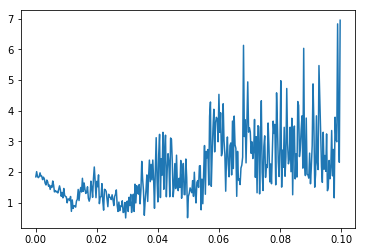

In [80]:
plt.plot(lrs, losses)
plt.show()

## Discriminative fine-tuning, gradual unfreezing, and 1-cycle triangular learning rate

### Initialize model with groups of layers

In [71]:
class ResnetV2(nn.Module):
    def __init__(self):
        super(ResnetV2, self).__init__()
        self.resnet = models.resnet34(pretrained=True)
        self.freeze()
        layers = list(self.resnet.children())[:8]
        self.groups = nn.ModuleList([nn.Sequential(*h) for h in [layers[:6], layers[6:]]]) # Define groups of layers
        self.groups.append(nn.Linear(512, 6))
    
    def forward(self, x):
        for group in self.groups[:2]: # Resnet layers
            x = group(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.groups[2](x) # Linear layer
        return x
    
    def freeze(self): # Freeze all Resnet
        for param in self.resnet.parameters():
            param.requires_grad = False
            
    def unfreeze(self, group_idx:int): # Unfreeze a group
        group = self.groups[group_idx]
        parameters = filter(lambda x: hasattr(x,'requires_grad'), group.parameters())
        for p in parameters: 
            p.requires_grad = True

In [72]:
def create_optimizer(model, lr0):
    param_groups = [list(model.groups[i].parameters()) for i in range(3)] # Different parameters groups for optimizer
    params = [{'params':p, 'lr': lr} for p,lr in zip(param_groups, [lr0/9, lr0/3, lr0])] # Different learning rates for groups
    return optim.Adam(params)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [73]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

### 1-cycle rate training, unfreeze top hidden layers for 30 epochs

In [74]:
def train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.05, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_acc = 0.0
    for j in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            lr = lrs[idx]
            update_optimizer(optimizer, [lr/9, lr/3, lr]) # In each iteration, update group learning rates
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            if idx == int(0.1*iterations):
                model.unfreeze(1)
                print(idx, "unfreezing 1")
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.73:
                path = "{0}/ft_gw_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)
    return sum_loss/total

In [75]:
batch_size = 50

In [76]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [77]:
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [78]:
model = ResnetV2().cuda()

In [79]:
val_metrics(model, valid_dl)

(1.866953260368771, 0.14333333333333334)

In [80]:
train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.05, epochs=30)

train_loss 1.353 val_loss 0.994 val_acc 0.652
train_loss 0.972 val_loss 0.925 val_acc 0.666
216 unfreezing 1
train_loss 0.915 val_loss 0.852 val_acc 0.692
train_loss 2.201 val_loss 1.918 val_acc 0.306
train_loss 1.356 val_loss 1.645 val_acc 0.486
train_loss 1.088 val_loss 1.418 val_acc 0.584
train_loss 0.971 val_loss 1.339 val_acc 0.551
train_loss 0.910 val_loss 8.872 val_acc 0.463
train_loss 0.802 val_loss 1.672 val_acc 0.513
train_loss 0.748 val_loss 1.074 val_acc 0.643
train_loss 0.710 val_loss 1.302 val_acc 0.618
train_loss 0.603 val_loss 1.327 val_acc 0.630
train_loss 0.582 val_loss 1.431 val_acc 0.616
train_loss 0.533 val_loss 0.826 val_acc 0.726
train_loss 0.508 val_loss 0.776 val_acc 0.741
train_loss 0.486 val_loss 0.942 val_acc 0.706
train_loss 0.419 val_loss 0.789 val_acc 0.772
/home/ubuntu/models/sandwich/ft_gw_resnet_77.pth
train_loss 0.389 val_loss 0.759 val_acc 0.760
train_loss 0.333 val_loss 0.769 val_acc 0.771
train_loss 0.277 val_loss 0.706 val_acc 0.786
/home/ubuntu/m

0.06040799119768457

In [81]:
model = ResnetV2().cuda()

In [82]:
load_model(model, model_path/"ft_gw_resnet_84.pth")

In [83]:
val_metrics(model, valid_dl)

(0.6399387800031238, 0.8355555555555556)

# II. Resnet34 on images preprocessed with Histogram Equalization

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [2]:
import cv2
import matplotlib.pyplot as plt 

In [3]:
PATH = Path("/home/ubuntu/data/sandwich/")

In [4]:
# list(PATH.iterdir())

In [5]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

## Data augmentation

In [6]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]


# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

## Train-validation split

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
def get_files(path):
    paths = [d for d in list(path.iterdir()) if d.is_dir()]
    files = [f for d in paths for f in list(d.iterdir())]
    return files

In [9]:
path = PATH/"he-train-315"

In [10]:
files = get_files(path)

In [11]:
# files

In [12]:
file_labels = [p.parts[-2] for p in files]

In [13]:
train_files, valid_files, y_train, y_valid = train_test_split(files, file_labels, test_size=0.2, random_state=42)

In [14]:
# from collections import Counter

In [15]:
# Counter(y_train), Counter(y_valid)

## Dataset

In [16]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [17]:
paths = [d for d in list(path.iterdir()) if d.is_dir()]

In [18]:
labels = [p.parts[-1] for p in paths]

In [19]:
labels

['hot_dog',
 'pulled_pork_sandwich',
 'grilled_cheese_sandwich',
 'lobster_roll_sandwich',
 'hamburger',
 'club_sandwich']

In [20]:
class SandwichDataset(Dataset):
    def __init__(self, files, labels, transforms=False):
        self.files = files
        self.label2ind = {v:k for k,v in enumerate(labels)}
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        name = path.parts[-1]
        y_class = self.label2ind[path.parts[-2]]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        if self.transforms:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
            x = random_crop(x)
        else:
            x = center_crop(x)
        x = normalize(x)
        y = self.label2ind[path.parts[-2]]
        return np.rollaxis(x, 2), y

In [21]:
train_ds = SandwichDataset(files=train_files, labels=labels, transforms=True)

In [22]:
valid_ds = SandwichDataset(files=valid_files, labels=labels, transforms=False)

In [23]:
# len(train_ds), len(valid_ds)

In [24]:
x, y = train_ds[0]

In [25]:
# x.shape, y

In [26]:
batch_size = 50

In [27]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [28]:
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [29]:
x, y = next(iter(train_dl))

In [30]:
x = x.cuda().float()
y = y.cuda()

In [31]:
# x.shape, y.shape

In [32]:
# y.shape[0]

## Initialize pre-trained model with frozen hidden layers

In [33]:
resnet = models.resnet34(pretrained=True)

In [34]:
layers = list(resnet.children())

In [35]:
# print(len(layers))

In [36]:
layers[-2:]

[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

In [37]:
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.fc = nn.Linear(512, 6)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        x = self.fc(x)
        return x

In [38]:
model = Resnet().cuda()

In [39]:
# x_features = model.top_model(x)

In [40]:
# x_features.shape

In [41]:
# x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features)

In [42]:
# x_features_ave.shape

In [43]:
# x_features_ave.size(0), x_features_ave.shape[0]

In [44]:
# x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)

In [45]:
# x_features_flatten.shape

In [46]:
out = model(x)

In [47]:
# out

In [48]:
_, pred = torch.max(out, 1)

In [49]:
# pred

In [50]:
# y

In [51]:
# pred.eq(y).sum()

In [52]:
F.cross_entropy(out, y).item()

1.9409763813018799

## Compute accuracy

In [53]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda()
        out = model(x)
        _, pred = torch.max(out, 1)
        correct += pred.eq(y).sum().item()
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    return sum_loss/total, correct/total

In [54]:
# val_metrics(model, valid_dl)

## Train model with fixed learning rate

In [55]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [56]:
model_path = Path("/home/ubuntu/models/sandwich/")

In [57]:
def get_optimizer(model, lr=0.01, wd=0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [58]:
def train(model, epochs=5, learning_rate=0.01):
    optimzer = get_optimizer(model, lr=learning_rate, wd=0)
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            total += batch
            sum_loss += batch*(loss.item())
        val_loss, val_acc = val_metrics(model, valid_dl)
        if i % 2 == 0:
            print("train loss %.3f val loss %.3f val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.6:
                path = "{0}/initial_he_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)

In [59]:
model = Resnet().cuda()

In [60]:
train(model, epochs=10, learning_rate=0.01)

train loss 1.464 val loss 1.064 val accuracy 0.599
/home/ubuntu/models/sandwich/initial_he_resnet_67.pth
train loss 0.901 val loss 0.885 val accuracy 0.682
/home/ubuntu/models/sandwich/initial_he_resnet_68.pth
train loss 0.872 val loss 1.032 val accuracy 0.649
train loss 0.854 val loss 0.911 val accuracy 0.697
/home/ubuntu/models/sandwich/initial_he_resnet_70.pth
train loss 0.845 val loss 0.958 val accuracy 0.700
/home/ubuntu/models/sandwich/initial_he_resnet_70.pth
/home/ubuntu/models/sandwich/initial_he_resnet_73.pth


In [61]:
# save_model(model, model_path/"initial_resnet.pth")

## Unfreeze top 2 hidden layers, train with lower learning rate for additional 20 epochs

In [58]:
model = Resnet().cuda()

In [59]:
load_model(model, model_path/"initial_he_resnet_73.pth")

In [60]:
val_metrics(model, valid_dl)

(0.8196046849091848, 0.7266666666666667)

In [61]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [62]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [63]:
unfreeze(model, 7)
unfreeze(model, 6)

In [64]:
def train2(model, epochs=5, learning_rate=0.01):
    optimzer = get_optimizer(model, lr=learning_rate, wd=0)
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            total += batch
            sum_loss += batch*(loss.item())
        val_loss, val_acc = val_metrics(model, valid_dl)
        if i % 2 == 0:
            print("train loss %.3f val loss %.3f val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.73:
                path = "{0}/unfreeze_he_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)

In [65]:
train2(model, epochs=20, learning_rate=0.001)

train loss 1.187 val loss 1.554 val accuracy 0.554
train loss 0.579 val loss 0.888 val accuracy 0.730
train loss 0.415 val loss 0.659 val accuracy 0.761
/home/ubuntu/models/sandwich/unfreeze_he_resnet_76.pth
train loss 0.322 val loss 0.857 val accuracy 0.743
/home/ubuntu/models/sandwich/unfreeze_he_resnet_77.pth
train loss 0.209 val loss 0.859 val accuracy 0.773
/home/ubuntu/models/sandwich/unfreeze_he_resnet_77.pth
/home/ubuntu/models/sandwich/unfreeze_he_resnet_77.pth
train loss 0.172 val loss 0.976 val accuracy 0.729
train loss 0.152 val loss 0.782 val accuracy 0.776
/home/ubuntu/models/sandwich/unfreeze_he_resnet_78.pth
/home/ubuntu/models/sandwich/unfreeze_he_resnet_81.pth
train loss 0.114 val loss 1.461 val accuracy 0.709
train loss 0.124 val loss 1.105 val accuracy 0.721
train loss 0.126 val loss 0.882 val accuracy 0.796


In [66]:
model = Resnet().cuda()

In [67]:
load_model(model, model_path/"/home/ubuntu/models/sandwich/unfreeze_he_resnet_81.pth")

In [68]:
val_metrics(model, valid_dl)

(0.7747624334361818, 0.8077777777777778)

## Learning rate range test

In [77]:
def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.1, epochs=5):
    losses = []
    p = model_path/"resnet_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    optimizer = get_optimizer(model, lr=lrs[0], wd=0.0)
    for i in range(epochs):
        for x, y in train_dl:
            update_optimizer(optimizer, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind += 1
            
    load_model(model, str(p))
    return lrs, losses

In [78]:
model = Resnet().cuda()

In [79]:
lrs, losses = LR_range_finder(model, train_dl)

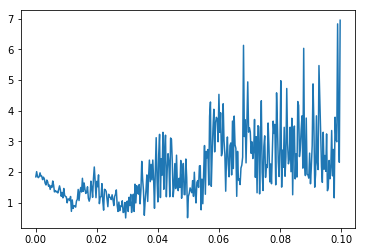

In [80]:
plt.plot(lrs, losses)
plt.show()

## Discriminative fine-tuning, gradual unfreezing, and 1-cycle triangular learning rate

### Initialize model with groups of layers

In [58]:
class ResnetV2(nn.Module):
    def __init__(self):
        super(ResnetV2, self).__init__()
        self.resnet = models.resnet34(pretrained=True)
        self.freeze()
        layers = list(self.resnet.children())[:8]
        self.groups = nn.ModuleList([nn.Sequential(*h) for h in [layers[:6], layers[6:]]]) # Define groups of layers
        self.groups.append(nn.Linear(512, 6))
    
    def forward(self, x):
        for group in self.groups[:2]: # Resnet layers
            x = group(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.groups[2](x) # Linear layer
        return x
    
    def freeze(self): # Freeze all Resnet
        for param in self.resnet.parameters():
            param.requires_grad = False
            
    def unfreeze(self, group_idx:int): # Unfreeze a group
        group = self.groups[group_idx]
        parameters = filter(lambda x: hasattr(x,'requires_grad'), group.parameters())
        for p in parameters: 
            p.requires_grad = True

In [59]:
def create_optimizer(model, lr0):
    param_groups = [list(model.groups[i].parameters()) for i in range(3)] # Different parameters groups for optimizer
    params = [{'params':p, 'lr': lr} for p,lr in zip(param_groups, [lr0/9, lr0/3, lr0])] # Different learning rates for groups
    return optim.Adam(params)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [60]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

### 1-cycle rate training, unfreeze top hidden layers, train for 30 epochs

In [75]:
def train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.05, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_acc = 0.0
    for j in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            lr = lrs[idx]
            update_optimizer(optimizer, [lr/9, lr/3, lr]) # In each iteration, update group learning rates
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            if idx == int(0.1*iterations):
                model.unfreeze(1)
                print(idx, "unfreezing 1")
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.73:
                path = "{0}/ft_he_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)
    return sum_loss/total

In [76]:
batch_size = 50

In [77]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [78]:
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [79]:
model = ResnetV2().cuda()

In [80]:
val_metrics(model, valid_dl)

(1.9079475204149883, 0.11333333333333333)

In [81]:
train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.05, epochs=30)

train_loss 1.397 val_loss 0.988 val_acc 0.689
train_loss 1.036 val_loss 1.000 val_acc 0.631
216 unfreezing 1
train_loss 1.077 val_loss 0.897 val_acc 0.670
train_loss 2.127 val_loss 9.386 val_acc 0.196
train_loss 1.388 val_loss 1.570 val_acc 0.441
train_loss 1.110 val_loss 1.665 val_acc 0.450
train_loss 1.015 val_loss 2.196 val_acc 0.463
train_loss 0.958 val_loss 1.205 val_acc 0.596
train_loss 0.857 val_loss 1.286 val_acc 0.647
train_loss 0.770 val_loss 1.006 val_acc 0.697
train_loss 0.729 val_loss 0.977 val_acc 0.673
train_loss 0.673 val_loss 1.476 val_acc 0.612
train_loss 0.586 val_loss 0.806 val_acc 0.729
train_loss 0.559 val_loss 0.926 val_acc 0.711
train_loss 0.525 val_loss 0.732 val_acc 0.769
/home/ubuntu/models/sandwich/ft_he_resnet_77.pth
train_loss 0.503 val_loss 0.755 val_acc 0.757
train_loss 0.447 val_loss 0.729 val_acc 0.757
train_loss 0.390 val_loss 0.827 val_acc 0.731
train_loss 0.359 val_loss 0.787 val_acc 0.779
/home/ubuntu/models/sandwich/ft_he_resnet_78.pth
train_loss 

0.0605154422745626

In [82]:
model = ResnetV2().cuda()

In [83]:
load_model(model, model_path/"ft_he_resnet_82.pth")

In [84]:
val_metrics(model, valid_dl)

(0.7643823739555147, 0.8155555555555556)

# III. Resnet34 on images preprocessed with Histogram Equalization + Grey World

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [2]:
import cv2
import matplotlib.pyplot as plt

In [3]:
PATH = Path("/home/ubuntu/data/sandwich/")

In [4]:
# list(PATH.iterdir())

In [5]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

## Data augmentation

In [6]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]


# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

## Train-validation split

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
def get_files(path):
    paths = [d for d in list(path.iterdir()) if d.is_dir()]
    files = [f for d in paths for f in list(d.iterdir())]
    return files

In [9]:
path = PATH/"hewg-train-315"

In [10]:
files = get_files(path)

In [11]:
# files

In [12]:
file_labels = [p.parts[-2] for p in files]

In [13]:
train_files, valid_files, y_train, y_valid = train_test_split(files, file_labels, test_size=0.2, random_state=42)

In [14]:
# from collections import Counter

In [15]:
# Counter(y_train), Counter(y_valid)

## Dataset

In [16]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [17]:
paths = [d for d in list(path.iterdir()) if d.is_dir()]

In [18]:
labels = [p.parts[-1] for p in paths]

In [19]:
labels

['hot_dog',
 'pulled_pork_sandwich',
 'grilled_cheese_sandwich',
 'lobster_roll_sandwich',
 'hamburger',
 'club_sandwich']

In [20]:
class SandwichDataset(Dataset):
    def __init__(self, files, labels, transforms=False):
        self.files = files
        self.label2ind = {v:k for k,v in enumerate(labels)}
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        name = path.parts[-1]
        y_class = self.label2ind[path.parts[-2]]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        if self.transforms:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
            x = random_crop(x)
        else:
            x = center_crop(x)
        x = normalize(x)
        y = self.label2ind[path.parts[-2]]
        return np.rollaxis(x, 2), y

In [21]:
train_ds = SandwichDataset(files=train_files, labels=labels, transforms=True)

In [22]:
valid_ds = SandwichDataset(files=valid_files, labels=labels, transforms=False)

In [23]:
# len(train_ds), len(valid_ds)

In [24]:
x, y = train_ds[0]

In [25]:
# x.shape, y

In [26]:
batch_size = 50

In [27]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [28]:
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [29]:
x, y = next(iter(train_dl))

In [30]:
x = x.cuda().float()
y = y.cuda()

In [31]:
# x.shape, y.shape

In [32]:
# y.shape[0]

## Initialize pre-trained model with frozen hidden layers

In [33]:
resnet = models.resnet34(pretrained=True)

In [34]:
layers = list(resnet.children())

In [35]:
# print(len(layers))

In [36]:
layers[-2:]

[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

In [37]:
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.fc = nn.Linear(512, 6)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        x = self.fc(x)
        return x

In [38]:
model = Resnet().cuda()

In [39]:
# x_features = model.top_model(x)

In [40]:
# x_features.shape

In [41]:
# x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features)

In [42]:
# x_features_ave.shape

In [43]:
# x_features_ave.size(0), x_features_ave.shape[0]

In [44]:
# x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)

In [45]:
# x_features_flatten.shape

In [46]:
out = model(x)

In [47]:
# out

In [48]:
_, pred = torch.max(out, 1)

In [49]:
# pred

In [50]:
# y

In [51]:
# pred.eq(y).sum()

In [52]:
F.cross_entropy(out, y).item()

1.9388099908828735

## Compute accuracy

In [53]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda()
        out = model(x)
        _, pred = torch.max(out, 1)
        correct += pred.eq(y).sum().item()
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    return sum_loss/total, correct/total

In [54]:
# val_metrics(model, valid_dl)

## Train model with fixed learning rate for 10 epochs

In [55]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [56]:
model_path = Path("/home/ubuntu/models/sandwich/")

In [57]:
def get_optimizer(model, lr=0.01, wd=0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [61]:
def train(model, epochs=5, learning_rate=0.01):
    optimzer = get_optimizer(model, lr=learning_rate, wd=0)
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            total += batch
            sum_loss += batch*(loss.item())
        val_loss, val_acc = val_metrics(model, valid_dl)
        if i % 2 == 0:
            print("train loss %.3f val loss %.3f val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.6:
                path = "{0}/initial_hewg_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)

In [62]:
model = Resnet().cuda()

In [63]:
train(model, epochs=10, learning_rate=0.01)

train loss 1.529 val loss 0.924 val accuracy 0.676
/home/ubuntu/models/sandwich/initial_hewg_resnet_68.pth
train loss 0.882 val loss 0.848 val accuracy 0.701
/home/ubuntu/models/sandwich/initial_hewg_resnet_70.pth
train loss 0.927 val loss 0.855 val accuracy 0.710
/home/ubuntu/models/sandwich/initial_hewg_resnet_71.pth
train loss 0.803 val loss 0.851 val accuracy 0.700
train loss 0.838 val loss 0.967 val accuracy 0.686


## Unfreeze top 2 hidden layers, train with lower learning rate for additional 20 epochs

In [81]:
model = Resnet().cuda()

In [82]:
load_model(model, model_path/"initial_hewg_resnet_71.pth")

In [83]:
val_metrics(model, valid_dl)

(0.8553838498062558, 0.71)

In [84]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [85]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [86]:
unfreeze(model, 7)
unfreeze(model, 6)

In [87]:
def train2(model, epochs=5, learning_rate=0.01):
    optimzer = get_optimizer(model, lr=learning_rate, wd=0)
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            total += batch
            sum_loss += batch*(loss.item())
        val_loss, val_acc = val_metrics(model, valid_dl)
        if i % 2 == 0:
            print("train loss %.3f val loss %.3f val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.71:
                path = "{0}/unfreeze_hewg_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)

In [88]:
train2(model, epochs=20, learning_rate=0.001)

train loss 1.216 val loss 0.944 val accuracy 0.671
train loss 0.562 val loss 0.796 val accuracy 0.732
/home/ubuntu/models/sandwich/unfreeze_hewg_resnet_73.pth
/home/ubuntu/models/sandwich/unfreeze_hewg_resnet_75.pth
train loss 0.385 val loss 0.665 val accuracy 0.780
/home/ubuntu/models/sandwich/unfreeze_hewg_resnet_78.pth
train loss 0.308 val loss 0.832 val accuracy 0.749
train loss 0.240 val loss 0.844 val accuracy 0.773
train loss 0.204 val loss 0.836 val accuracy 0.761
train loss 0.139 val loss 0.943 val accuracy 0.768
/home/ubuntu/models/sandwich/unfreeze_hewg_resnet_79.pth
train loss 0.125 val loss 0.858 val accuracy 0.772
train loss 0.111 val loss 0.883 val accuracy 0.778
train loss 0.083 val loss 0.861 val accuracy 0.777
/home/ubuntu/models/sandwich/unfreeze_hewg_resnet_82.pth


In [89]:
model = Resnet().cuda()

In [90]:
load_model(model, model_path/"/home/ubuntu/models/sandwich/unfreeze_hewg_resnet_82.pth")

In [91]:
val_metrics(model, valid_dl)

(0.7238615949948629, 0.8211111111111111)

## Learning rate range test

In [77]:
def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.1, epochs=5):
    losses = []
    p = model_path/"resnet_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    optimizer = get_optimizer(model, lr=lrs[0], wd=0.0)
    for i in range(epochs):
        for x, y in train_dl:
            update_optimizer(optimizer, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind += 1
            
    load_model(model, str(p))
    return lrs, losses

In [78]:
model = Resnet().cuda()

In [79]:
lrs, losses = LR_range_finder(model, train_dl)

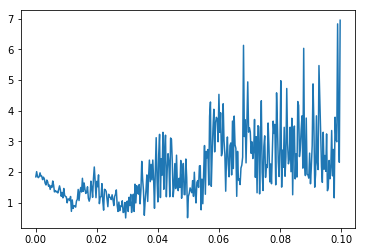

In [80]:
plt.plot(lrs, losses)
plt.show()

## Discriminative fine-tuning, gradual unfreezing, and 1-cycle triangular learning rate

### Initialize model with groups of layers

In [92]:
class ResnetV2(nn.Module):
    def __init__(self):
        super(ResnetV2, self).__init__()
        self.resnet = models.resnet34(pretrained=True)
        self.freeze()
        layers = list(self.resnet.children())[:8]
        self.groups = nn.ModuleList([nn.Sequential(*h) for h in [layers[:6], layers[6:]]]) # Define groups of layers
        self.groups.append(nn.Linear(512, 6))
    
    def forward(self, x):
        for group in self.groups[:2]: # Resnet layers
            x = group(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.groups[2](x) # Linear layer
        return x
    
    def freeze(self): # Freeze all Resnet
        for param in self.resnet.parameters():
            param.requires_grad = False
            
    def unfreeze(self, group_idx:int): # Unfreeze a group
        group = self.groups[group_idx]
        parameters = filter(lambda x: hasattr(x,'requires_grad'), group.parameters())
        for p in parameters: 
            p.requires_grad = True

In [93]:
def create_optimizer(model, lr0):
    param_groups = [list(model.groups[i].parameters()) for i in range(3)] # Different parameters groups for optimizer
    params = [{'params':p, 'lr': lr} for p,lr in zip(param_groups, [lr0/9, lr0/3, lr0])] # Different learning rates for groups
    return optim.Adam(params)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

### 1-cycle rate training, unfreeze top hidden layers, train for 30 epochs

In [94]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

In [95]:
def train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.05, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_acc = 0.0
    for j in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            lr = lrs[idx]
            update_optimizer(optimizer, [lr/9, lr/3, lr]) # In each iteration, update group learning rates
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            if idx == int(0.1*iterations):
                model.unfreeze(1)
                print(idx, "unfreezing 1")
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.71:
                path = "{0}/ft_hewg_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)
    return sum_loss/total

In [96]:
batch_size = 50

In [97]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [98]:
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [99]:
model = ResnetV2().cuda()

In [100]:
val_metrics(model, valid_dl)

(1.875699394279056, 0.17222222222222222)

In [101]:
train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.05, epochs=30)

train_loss 1.430 val_loss 1.065 val_acc 0.650
train_loss 1.034 val_loss 0.911 val_acc 0.681
216 unfreezing 1
train_loss 1.037 val_loss 1.255 val_acc 0.571
train_loss 1.843 val_loss 1.433 val_acc 0.500
train_loss 1.302 val_loss 1.505 val_acc 0.457
train_loss 1.252 val_loss 224.853 val_acc 0.220
train_loss 1.065 val_loss 2.609 val_acc 0.351
train_loss 0.897 val_loss 1.179 val_acc 0.589
train_loss 0.819 val_loss 1.554 val_acc 0.622
train_loss 0.766 val_loss 0.850 val_acc 0.726
/home/ubuntu/models/sandwich/ft_hewg_resnet_73.pth
train_loss 0.741 val_loss 1.121 val_acc 0.640
train_loss 0.710 val_loss 0.771 val_acc 0.746
/home/ubuntu/models/sandwich/ft_hewg_resnet_75.pth
train_loss 0.663 val_loss 1.112 val_acc 0.650
train_loss 0.593 val_loss 0.764 val_acc 0.752
/home/ubuntu/models/sandwich/ft_hewg_resnet_75.pth
train_loss 0.534 val_loss 0.713 val_acc 0.773
/home/ubuntu/models/sandwich/ft_hewg_resnet_77.pth
train_loss 0.489 val_loss 0.770 val_acc 0.777
/home/ubuntu/models/sandwich/ft_hewg_resn

0.07116714126378712

In [102]:
model = ResnetV2().cuda()

In [103]:
load_model(model, model_path/"/home/ubuntu/models/sandwich/ft_hewg_resnet_82.pth")

In [104]:
val_metrics(model, valid_dl)

(0.7655745827489429, 0.8222222222222222)

# IV. Resnet34 with Grey World + Histogram Equalization as a random data augmentation

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

In [2]:
import cv2
import matplotlib.pyplot as plt

import colorcorrect.algorithm as cca

In [3]:
PATH = Path("/home/ubuntu/data/sandwich/")

In [4]:
# list(PATH.iterdir())

In [5]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

## Data augmentation

In [6]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]


# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [7]:
def gwhe_img(img):
    img = cca.grey_world(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(img_y_cr_cb)
    y_eq = cv2.equalizeHist(y)
    img_y_cr_cb_eq = cv2.merge((y_eq, cr, cb))
    img_rgb_eq = cv2.cvtColor(img_y_cr_cb_eq, cv2.COLOR_YCR_CB2BGR)
    return cv2.cvtColor(img_rgb_eq, cv2.COLOR_RGB2BGR)

## Train-validation split

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
def get_files(path):
    paths = [d for d in list(path.iterdir()) if d.is_dir()]
    files = [f for d in paths for f in list(d.iterdir())]
    return files

In [10]:
path = PATH/"train-315"

In [11]:
files = get_files(path)

In [12]:
# files

In [13]:
file_labels = [p.parts[-2] for p in files]

In [14]:
train_files, valid_files, y_train, y_valid = train_test_split(files, file_labels, test_size=0.2, random_state=42)

In [15]:
# from collections import Counter

In [16]:
# Counter(y_train), Counter(y_valid)

## Dataset

In [17]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [18]:
paths = [d for d in list(path.iterdir()) if d.is_dir()]

In [19]:
labels = [p.parts[-1] for p in paths]

In [20]:
labels

['hot_dog',
 'pulled_pork_sandwich',
 'grilled_cheese_sandwich',
 'lobster_roll_sandwich',
 'hamburger',
 'club_sandwich']

In [21]:
class SandwichDataset(Dataset):
    def __init__(self, files, labels, transforms=False):
        self.files = files
        self.label2ind = {v:k for k,v in enumerate(labels)}
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        name = path.parts[-1]
        y_class = self.label2ind[path.parts[-2]] 
        x = cv2.imread(str(path)).astype(np.float32)
        if self.transforms:
            # Randomly apply Grey World and Histogram Equalization to image
            if np.random.random() > 0.5: x = gwhe_img(x).copy()
            x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
            if np.random.random() > 0.5: x = np.fliplr(x).copy()
            x = random_crop(x)
        else:
            x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
            x = center_crop(x)
        x = normalize(x)
        y = self.label2ind[path.parts[-2]]
        return np.rollaxis(x, 2), y

In [22]:
train_ds = SandwichDataset(files=train_files, labels=labels, transforms=True)

In [23]:
# train_ds.label2ind

In [24]:
valid_ds = SandwichDataset(files=valid_files, labels=labels, transforms=False)

In [25]:
# valid_ds.label2ind

In [26]:
# len(train_ds), len(valid_ds)

In [27]:
x, y = train_ds[0]

In [28]:
# x.shape, y

In [29]:
batch_size = 50

In [30]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [31]:
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

In [32]:
x, y = next(iter(train_dl))

In [33]:
x = x.cuda().float()
y = y.cuda()

In [34]:
# x.shape, y.shape

In [35]:
# y.shape[0]

## Initialize pre-trained model with frozen hidden layers

In [36]:
resnet = models.resnet34(pretrained=True)

In [37]:
layers = list(resnet.children())

In [38]:
# print(len(layers))

In [39]:
layers[-2:]

[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

In [40]:
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.fc = nn.Linear(512, 6)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        x = self.fc(x)
        return x

In [41]:
model = Resnet().cuda()

In [42]:
# x_features = model.top_model(x)

In [43]:
# x_features.shape

In [44]:
# x_features_ave = nn.AdaptiveAvgPool2d((1,1))(x_features)

In [45]:
# x_features_ave.shape

In [46]:
# x_features_ave.size(0), x_features_ave.shape[0]

In [47]:
# x_features_flatten = x_features_ave.view(x_features_ave.shape[0], -1)

In [48]:
# x_features_flatten.shape

In [49]:
out = model(x)

In [50]:
# out

In [51]:
_, pred = torch.max(out, 1)

In [52]:
# pred

In [53]:
# y

In [54]:
# pred.eq(y).sum()

In [55]:
F.cross_entropy(out, y).item()

2.0690958499908447

## Compute accuracy

In [56]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda()
        out = model(x)
        _, pred = torch.max(out, 1)
        correct += pred.eq(y).sum().item()
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    return sum_loss/total, correct/total

In [57]:
# val_metrics(model, valid_dl)

## Train model with fixed learning rate for 10 epochs

In [58]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [59]:
model_path = Path("/home/ubuntu/models/sandwich/")

In [60]:
def get_optimizer(model, lr=0.01, wd=0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [62]:
def train(model, epochs=5, learning_rate=0.01):
    optimzer = get_optimizer(model, lr=learning_rate, wd=0)
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            total += batch
            sum_loss += batch*(loss.item())
        val_loss, val_acc = val_metrics(model, valid_dl)
        if i % 2 == 0:
            print("train loss %.3f val loss %.3f val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
        if val_acc > prev_val_acc:
            prev_val_acc = val_acc
            if val_acc > 0.6:
                path = "{0}/initial_aug_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)

In [63]:
model = Resnet().cuda()

In [64]:
train(model, epochs=10, learning_rate=0.01)

train loss 1.554 val loss 0.914 val accuracy 0.670
/home/ubuntu/models/sandwich/initial_aug_resnet_67.pth
/home/ubuntu/models/sandwich/initial_aug_resnet_69.pth
train loss 0.942 val loss 0.853 val accuracy 0.698
/home/ubuntu/models/sandwich/initial_aug_resnet_70.pth
train loss 0.887 val loss 1.004 val accuracy 0.649
/home/ubuntu/models/sandwich/initial_aug_resnet_73.pth
train loss 0.814 val loss 0.720 val accuracy 0.754
/home/ubuntu/models/sandwich/initial_aug_resnet_75.pth
train loss 0.808 val loss 0.847 val accuracy 0.739


In [65]:
# save_model(model, model_path/"initial_resnet.pth")

## Unfreeze top 2 hidden layers, train with lower learning rate for additional 20 epochs

In [66]:
model = Resnet().cuda()

In [67]:
load_model(model, model_path/"initial_aug_resnet_75.pth")

In [68]:
val_metrics(model, valid_dl)

(0.7203980055120256, 0.7544444444444445)

In [69]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [70]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [71]:
unfreeze(model, 7)
unfreeze(model, 6)

In [72]:
def train2(model, epochs=5, learning_rate=0.01):
    optimzer = get_optimizer(model, lr=learning_rate, wd=0)
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y in train_dl:
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            total += batch
            sum_loss += batch*(loss.item())
        val_loss, val_acc = val_metrics(model, valid_dl)
        if i % 2 == 0:
            print("train loss %.3f val loss %.3f val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.75:
                path = "{0}/unfreeze_aug_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)

In [73]:
train2(model, epochs=20, learning_rate=0.001)

train loss 1.147 val loss 0.806 val accuracy 0.738
train loss 0.583 val loss 0.887 val accuracy 0.706
/home/ubuntu/models/sandwich/unfreeze_aug_resnet_76.pth
train loss 0.426 val loss 0.750 val accuracy 0.763
/home/ubuntu/models/sandwich/unfreeze_aug_resnet_77.pth
train loss 0.333 val loss 0.777 val accuracy 0.773
/home/ubuntu/models/sandwich/unfreeze_aug_resnet_79.pth
train loss 0.240 val loss 1.349 val accuracy 0.688
train loss 0.213 val loss 0.700 val accuracy 0.801
/home/ubuntu/models/sandwich/unfreeze_aug_resnet_80.pth
/home/ubuntu/models/sandwich/unfreeze_aug_resnet_82.pth
train loss 0.173 val loss 0.758 val accuracy 0.790
train loss 0.146 val loss 0.823 val accuracy 0.799
/home/ubuntu/models/sandwich/unfreeze_aug_resnet_83.pth
train loss 0.102 val loss 0.874 val accuracy 0.809
train loss 0.149 val loss 0.834 val accuracy 0.799
/home/ubuntu/models/sandwich/unfreeze_aug_resnet_84.pth


In [74]:
model = Resnet().cuda()

In [75]:
load_model(model, model_path/"/home/ubuntu/models/sandwich/unfreeze_aug_resnet_84.pth")

In [76]:
val_metrics(model, valid_dl)

(0.609929227994548, 0.8377777777777777)

## Learning rate range test

In [77]:
def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=0.1, epochs=5):
    losses = []
    p = model_path/"resnet_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    optimizer = get_optimizer(model, lr=lrs[0], wd=0.0)
    for i in range(epochs):
        for x, y in train_dl:
            update_optimizer(optimizer, lr=lrs[ind])
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            ind += 1
            
    load_model(model, str(p))
    return lrs, losses

In [78]:
model = Resnet().cuda()

In [79]:
lrs, losses = LR_range_finder(model, train_dl)

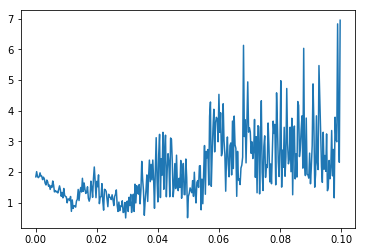

In [80]:
plt.plot(lrs, losses)
plt.show()

## Discriminative fine-tuning, gradual unfreezing, and 1-cycle triangular learning rate

### Initialize model with groups of layers

In [77]:
class ResnetV2(nn.Module):
    def __init__(self):
        super(ResnetV2, self).__init__()
        self.resnet = models.resnet34(pretrained=True)
        self.freeze()
        layers = list(self.resnet.children())[:8]
        self.groups = nn.ModuleList([nn.Sequential(*h) for h in [layers[:6], layers[6:]]]) # Define groups of layers
        self.groups.append(nn.Linear(512, 6))
    
    def forward(self, x):
        for group in self.groups[:2]: # Resnet layers
            x = group(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.groups[2](x) # Linear layer
        return x
    
    def freeze(self): # Freeze all Resnet
        for param in self.resnet.parameters():
            param.requires_grad = False
            
    def unfreeze(self, group_idx:int): # Unfreeze a group
        group = self.groups[group_idx]
        parameters = filter(lambda x: hasattr(x,'requires_grad'), group.parameters())
        for p in parameters: 
            p.requires_grad = True

In [78]:
def create_optimizer(model, lr0):
    param_groups = [list(model.groups[i].parameters()) for i in range(3)] # Different parameters groups for optimizer
    params = [{'params':p, 'lr': lr} for p,lr in zip(param_groups, [lr0/9, lr0/3, lr0])] # Different learning rates for groups
    return optim.Adam(params)

def update_optimizer(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [79]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

### 1-cycle rate training, unfreeze top hidden layers, train for 30 epochs

In [86]:
def train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.05, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer(model, lrs[0])
    prev_val_acc = 0.0
    for j in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            lr = lrs[idx]
            update_optimizer(optimizer, [lr/9, lr/3, lr]) # In each iteration, update group learning rates
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            if idx == int(0.1*iterations):
                model.unfreeze(1)
                print(idx, "unfreezing 1")
            total += batch
            sum_loss += batch*(loss.item())
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        if val_acc > prev_val_acc: 
            prev_val_acc = val_acc
            if val_acc > 0.73:
                path = "{0}/ft_aug_resnet_{1:.0f}.pth".format(model_path, 100*val_acc)
                save_model(model, path)
                print(path)
    return sum_loss/total

In [87]:
model = ResnetV2().cuda()

In [88]:
val_metrics(model, valid_dl)

(1.9267942772971258, 0.14333333333333334)

In [89]:
train_triangular_policy2(model, train_dl, valid_dl, max_lr=0.05, epochs=30)

train_loss 1.381 val_loss 0.952 val_acc 0.688
train_loss 0.961 val_loss 0.945 val_acc 0.629
216 unfreezing 1
train_loss 0.981 val_loss 0.865 val_acc 0.689
train_loss 2.271 val_loss 2.265 val_acc 0.287
train_loss 1.390 val_loss 1.379 val_acc 0.510
train_loss 1.419 val_loss 19.780 val_acc 0.309
train_loss 1.239 val_loss 1.508 val_acc 0.492
train_loss 0.990 val_loss 1.410 val_acc 0.534
train_loss 0.911 val_loss 0.986 val_acc 0.709
train_loss 0.843 val_loss 1.233 val_acc 0.563
train_loss 0.789 val_loss 0.734 val_acc 0.744
/home/ubuntu/models/sandwich/ft_aug_resnet_74.pth
train_loss 0.735 val_loss 0.984 val_acc 0.674
train_loss 0.661 val_loss 1.081 val_acc 0.674
train_loss 0.612 val_loss 0.810 val_acc 0.728
train_loss 0.585 val_loss 0.690 val_acc 0.789
/home/ubuntu/models/sandwich/ft_aug_resnet_79.pth
train_loss 0.567 val_loss 0.890 val_acc 0.718
train_loss 0.565 val_loss 0.944 val_acc 0.713
train_loss 0.466 val_loss 0.848 val_acc 0.761
train_loss 0.455 val_loss 0.686 val_acc 0.779
train_lo

0.12141090502134627

In [90]:
model = ResnetV2().cuda()

In [91]:
load_model(model, model_path/"ft_aug_resnet_84.pth")

In [92]:
val_metrics(model, valid_dl)

(0.6474739015102386, 0.8355555555555556)